In [2]:
import pandas as pd
 
# Load the dataset
df = pd.read_csv(
    '/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv'
)
 
# Check nulls
print(df.isnull().sum())
 
# Replace missing reviews with a fallback string if needed
if df['review'].isnull().sum() > 0:
    review_mode = df['review'].mode()
    if not review_mode.empty:
        df['review'].fillna(review_mode[0], inplace=True)
    else:
        df['review'].fillna("No review available", inplace=True)
 
# Convert sentiment labels to binary: positive → 1, negative → 0
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})
 
# Keep only necessary columns
df = df[['review', 'label']].rename(columns={'review': 'tweet_text'})
 
# Display class distribution
print(df['label'].value_counts())

review       0
sentiment    0
dtype: int64
label
1    25000
0    25000
Name: count, dtype: int64


In [4]:
!pip install transformers -q
!pip install scikit-learn -q
!pip install transformers torch sklearn matplotlib
 
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
 
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW  
 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
from tqdm import tqdm

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


# Bert

Balanced class counts:
label
0    5000
1    5000
Name: count, dtype: int64


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 438/438 [03:05<00:00,  2.36it/s]


Epoch 1: Train Loss=0.3863, Val Loss=0.3201, Train Acc=0.8211, Val Acc=0.8550


Epoch 2: 100%|██████████| 438/438 [03:22<00:00,  2.16it/s]


Epoch 2: Train Loss=0.2014, Val Loss=0.3520, Train Acc=0.9226, Val Acc=0.8800


Epoch 3: 100%|██████████| 438/438 [03:22<00:00,  2.16it/s]


Epoch 3: Train Loss=0.1063, Val Loss=0.3617, Train Acc=0.9657, Val Acc=0.8740


Epoch 4: 100%|██████████| 438/438 [03:22<00:00,  2.16it/s]


Epoch 4: Train Loss=0.0528, Val Loss=0.4510, Train Acc=0.9841, Val Acc=0.8770


Epoch 5: 100%|██████████| 438/438 [03:22<00:00,  2.16it/s]


Epoch 5: Train Loss=0.0365, Val Loss=0.5429, Train Acc=0.9877, Val Acc=0.8680


Epoch 6: 100%|██████████| 438/438 [03:22<00:00,  2.16it/s]


Epoch 6: Train Loss=0.0253, Val Loss=0.7061, Train Acc=0.9917, Val Acc=0.8640
Early stopping

Final Test Metrics:
Accuracy: 0.8590
Precision: 0.9007
Recall: 0.8070
F1-Score: 0.8513
MCC: 0.7219
MAE: 0.1410
MSE: 0.1410
RMSE: 0.3755
Cohen's Kappa: 0.7180
AUC-ROC: 0.9391
CSI: 0.7410


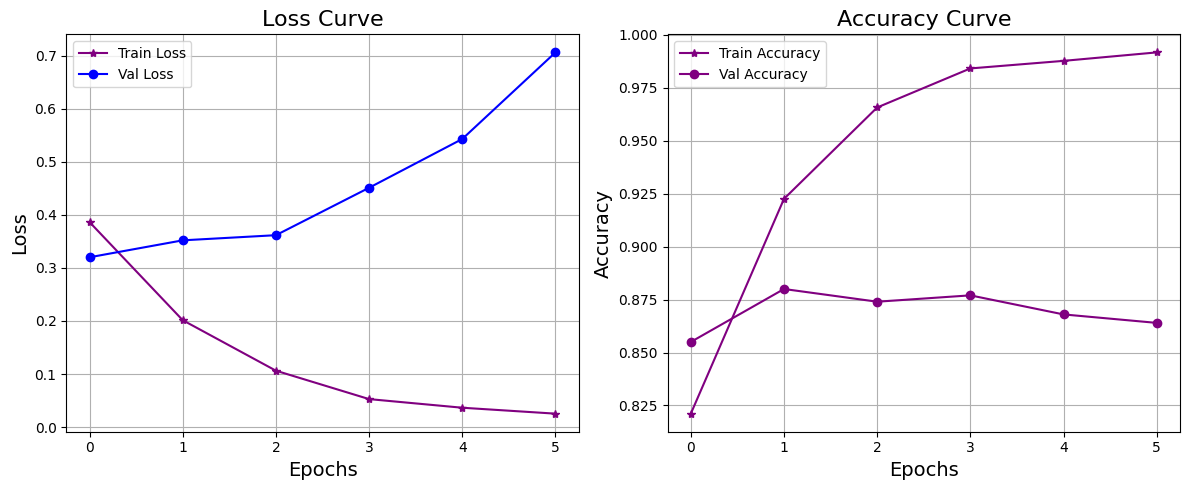

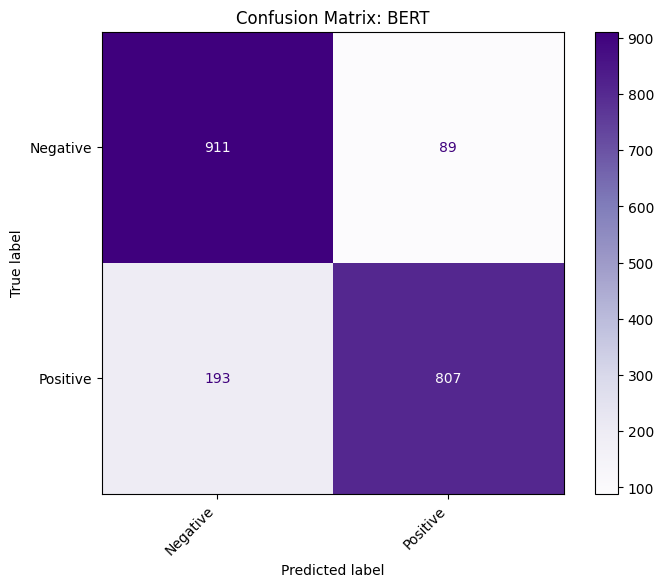

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, accuracy_score,
    precision_recall_fscore_support, matthews_corrcoef,
    mean_absolute_error, mean_squared_error,
    cohen_kappa_score, roc_auc_score
)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
 
# === 1. Balance dataset by downsampling to 5k/class ===
sample_size = 5000
balanced_df = pd.concat([
    df[df['label'] == cls].sample(sample_size, random_state=42)
    for cls in df['label'].unique()
]).sample(frac=1, random_state=42).reset_index(drop=True)
 
print("Balanced class counts:")
print(balanced_df['label'].value_counts())
 
# === 2. Split into 70% train, 20% test, 10% val ===
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    balanced_df['tweet_text'], balanced_df['label'],
    test_size=0.3, stratify=balanced_df['label'], random_state=42
)
 
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels,
    test_size=2/3, stratify=temp_labels, random_state=42
)
 
# === 3. Tokenization ===
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
 
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len
 
    def __len__(self):
        return len(self.labels)
 
    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            max_length=self.max_len,
            padding='max_length',
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }
 
train_dataset = TweetDataset(train_texts, train_labels, tokenizer)
val_dataset = TweetDataset(val_texts, val_labels, tokenizer)
test_dataset = TweetDataset(test_texts, test_labels, tokenizer)
 
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)
 
# === 4. Model Setup ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)
 
# === 5. Training ===
train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []
best_val_loss = float('inf')
patience = 5
num_epochs = 30
trigger_times = 0
 
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    correct_train = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
 
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        loss.backward()
        optimizer.step()
 
        total_train_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct_train += (preds == labels).sum().item()
 
    avg_train_loss = total_train_loss / len(train_loader)
    train_acc = correct_train / len(train_dataset)
 
    model.eval()
    val_loss = 0
    correct_val = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            correct_val += (preds == labels).sum().item()
 
    avg_val_loss = val_loss / len(val_loader)
    val_acc = correct_val / len(val_dataset)
 
    train_loss_list.append(avg_train_loss)
    val_loss_list.append(avg_val_loss)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
 
    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")
 
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping")
            break
 
# === 6. Load Best Model and Evaluate ===
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
all_preds, all_labels, all_probs = [], [], []
 
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        probs = torch.softmax(outputs.logits, dim=1)[:, 1]
        preds = torch.argmax(outputs.logits, dim=1)
 
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
 
# === 7. Metrics ===
test_acc = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
mcc = matthews_corrcoef(all_labels, all_preds)
mae = mean_absolute_error(all_labels, all_preds)
mse = mean_squared_error(all_labels, all_preds)
rmse = np.sqrt(mse)
kappa = cohen_kappa_score(all_labels, all_preds)
auc_roc = roc_auc_score(all_labels, all_probs)
cm = confusion_matrix(all_labels, all_preds)
TP = cm[1,1]
FN = cm[1,0]
FP = cm[0,1]
CSI = TP / (TP + FN + FP) if (TP + FN + FP) > 0 else 0
 
print("\nFinal Test Metrics:")
print(f"Accuracy: {test_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"MCC: {mcc:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"CSI: {CSI:.4f}")
 
# === 8. Plot Loss and Accuracy Curves ===
plt.figure(figsize=(12, 5))
 
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train Loss', color='purple', marker='*')
plt.plot(val_loss_list, label='Val Loss', color='blue', marker='o')
plt.title("Loss Curve", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True)
plt.legend()
 
plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='Train Accuracy', color='purple', marker='*')
plt.plot(val_acc_list, label='Val Accuracy', color='purple', marker='o')
plt.title("Accuracy Curve", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.grid(True)
plt.legend()
 
plt.tight_layout()
plt.savefig('Bert1_training_curves.png', dpi=300)
plt.show()
 
# === 9. Confusion Matrix ===
labels = ['Negative', 'Positive']
conf_matrix = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap=plt.cm.Purples, values_format='d')
plt.title('Confusion Matrix: BERT', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.rcParams.update({'font.size': 16})
plt.savefig('confusion_matrix.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

# *Roberta***

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 438/438 [02:46<00:00,  2.63it/s]


Epoch 1: Train Loss=0.3605, Val Loss=0.2820, Train Acc=0.8391, Val Acc=0.8840


Epoch 2: 100%|██████████| 438/438 [02:48<00:00,  2.59it/s]


Epoch 2: Train Loss=0.2229, Val Loss=0.2635, Train Acc=0.9150, Val Acc=0.8990


Epoch 3: 100%|██████████| 438/438 [02:48<00:00,  2.59it/s]


Epoch 3: Train Loss=0.1459, Val Loss=0.2389, Train Acc=0.9446, Val Acc=0.9000


Epoch 4: 100%|██████████| 438/438 [02:48<00:00,  2.59it/s]


Epoch 4: Train Loss=0.0986, Val Loss=0.3920, Train Acc=0.9676, Val Acc=0.8890


Epoch 5: 100%|██████████| 438/438 [02:48<00:00,  2.59it/s]


Epoch 5: Train Loss=0.0709, Val Loss=0.3925, Train Acc=0.9767, Val Acc=0.8900


Epoch 6: 100%|██████████| 438/438 [02:48<00:00,  2.60it/s]


Epoch 6: Train Loss=0.0447, Val Loss=0.4552, Train Acc=0.9841, Val Acc=0.8900


Epoch 7: 100%|██████████| 438/438 [02:48<00:00,  2.60it/s]


Epoch 7: Train Loss=0.0322, Val Loss=0.4599, Train Acc=0.9896, Val Acc=0.8940


Epoch 8: 100%|██████████| 438/438 [02:48<00:00,  2.60it/s]


Epoch 8: Train Loss=0.0363, Val Loss=0.5993, Train Acc=0.9880, Val Acc=0.8880
Early stopping

Final Test Metrics:
Accuracy: 0.8955
Precision: 0.9056
Recall: 0.8830
F1-Score: 0.8942
MCC: 0.7912
MAE: 0.1045
MSE: 0.1045
RMSE: 0.3233
Cohen's Kappa: 0.7910
AUC-ROC: 0.9605
CSI: 0.8086


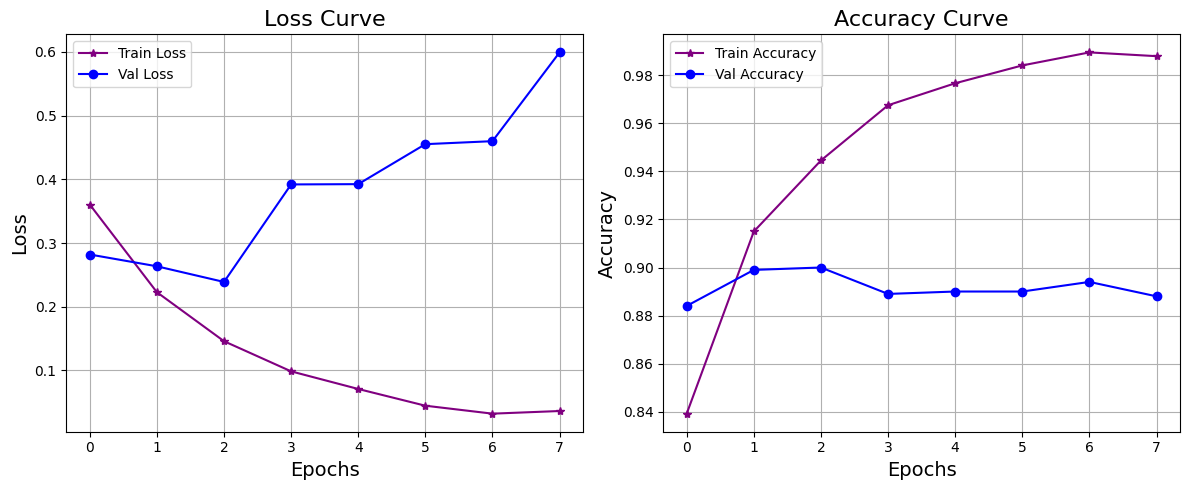

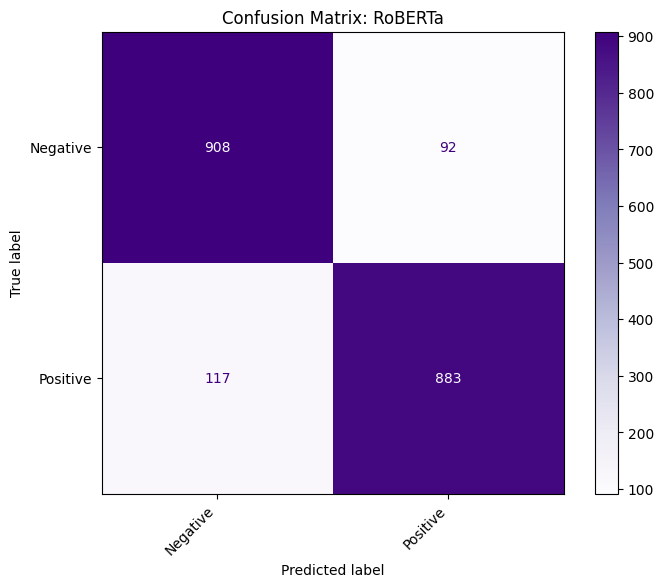

In [3]:
import torch

import torch.nn as nn

from torch.utils.data import Dataset, DataLoader

from transformers import RobertaTokenizer, RobertaForSequenceClassification

from torch.optim import AdamW

from sklearn.model_selection import train_test_split

from sklearn.metrics import (

    confusion_matrix, ConfusionMatrixDisplay, accuracy_score,

    precision_recall_fscore_support, matthews_corrcoef,

    mean_absolute_error, mean_squared_error,

    cohen_kappa_score, roc_auc_score

)

import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

from tqdm import tqdm
 
# === 1. Balance dataset to exactly 5000 per class ===

sample_size = 5000

balanced_df = pd.concat([

    df[df['label'] == cls].sample(sample_size, random_state=42)

    for cls in df['label'].unique()

]).sample(frac=1, random_state=42).reset_index(drop=True)
 
# === 2. Split into train/val/test (70/10/20) ===

train_texts, temp_texts, train_labels, temp_labels = train_test_split(

    balanced_df['tweet_text'], balanced_df['label'],

    test_size=0.3, stratify=balanced_df['label'], random_state=42

)

val_texts, test_texts, val_labels, test_labels = train_test_split(

    temp_texts, temp_labels,

    test_size=2/3, stratify=temp_labels, random_state=42

)
 
# === 3. Tokenization ===

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
 
class TweetDataset(Dataset):

    def __init__(self, texts, labels, tokenizer, max_len=128):

        self.texts = texts.tolist()

        self.labels = labels.tolist()

        self.tokenizer = tokenizer

        self.max_len = max_len
 
    def __len__(self):

        return len(self.labels)
 
    def __getitem__(self, idx):

        encoding = self.tokenizer(

            self.texts[idx],

            truncation=True,

            max_length=self.max_len,

            padding='max_length',

            return_tensors='pt'

        )

        return {

            'input_ids': encoding['input_ids'].squeeze(0),

            'attention_mask': encoding['attention_mask'].squeeze(0),

            'labels': torch.tensor(self.labels[idx], dtype=torch.long)

        }
 
train_dataset = TweetDataset(train_texts, train_labels, tokenizer)

val_dataset = TweetDataset(val_texts, val_labels, tokenizer)

test_dataset = TweetDataset(test_texts, test_labels, tokenizer)
 
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=16)

test_loader = DataLoader(test_dataset, batch_size=16)
 
# === 4. Model Setup ===

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2).to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
 
# === 5. Training ===

train_loss_list, val_loss_list = [], []

train_acc_list, val_acc_list = [], []

best_val_loss = float('inf')

patience = 5

num_epochs = 30

trigger_times = 0
 
for epoch in range(num_epochs):

    model.train()

    total_train_loss = 0

    correct_train = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):

        input_ids = batch['input_ids'].to(device)

        attention_mask = batch['attention_mask'].to(device)

        labels = batch['labels'].to(device)
 
        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

        loss = outputs.loss

        logits = outputs.logits

        loss.backward()

        optimizer.step()
 
        total_train_loss += loss.item()

        preds = torch.argmax(logits, dim=1)

        correct_train += (preds == labels).sum().item()
 
    avg_train_loss = total_train_loss / len(train_loader)

    train_acc = correct_train / len(train_dataset)
 
    model.eval()

    val_loss = 0

    correct_val = 0

    with torch.no_grad():

        for batch in val_loader:

            input_ids = batch['input_ids'].to(device)

            attention_mask = batch['attention_mask'].to(device)

            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

            val_loss += outputs.loss.item()

            preds = torch.argmax(outputs.logits, dim=1)

            correct_val += (preds == labels).sum().item()
 
    avg_val_loss = val_loss / len(val_loader)

    val_acc = correct_val / len(val_dataset)
 
    train_loss_list.append(avg_train_loss)

    val_loss_list.append(avg_val_loss)

    train_acc_list.append(train_acc)

    val_acc_list.append(val_acc)
 
    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")
 
    if avg_val_loss < best_val_loss:

        best_val_loss = avg_val_loss

        trigger_times = 0

        torch.save(model.state_dict(), 'best_roberta.pth')

    else:

        trigger_times += 1

        if trigger_times >= patience:

            print("Early stopping")

            break
 
# === 6. Load Best Model and Evaluate ===

model.load_state_dict(torch.load('best_roberta.pth'))

model.eval()

all_preds, all_labels, all_probs = [], [], []
 
with torch.no_grad():

    for batch in test_loader:

        input_ids = batch['input_ids'].to(device)

        attention_mask = batch['attention_mask'].to(device)

        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)

        probs = torch.softmax(outputs.logits, dim=1)[:, 1]

        preds = torch.argmax(outputs.logits, dim=1)
 
        all_preds.extend(preds.cpu().numpy())

        all_labels.extend(labels.cpu().numpy())

        all_probs.extend(probs.cpu().numpy())
 
# === 7. Metrics ===

test_acc = accuracy_score(all_labels, all_preds)

precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')

mcc = matthews_corrcoef(all_labels, all_preds)

mae = mean_absolute_error(all_labels, all_preds)

mse = mean_squared_error(all_labels, all_preds)

rmse = np.sqrt(mse)

kappa = cohen_kappa_score(all_labels, all_preds)

auc_roc = roc_auc_score(all_labels, all_probs)

cm = confusion_matrix(all_labels, all_preds)

TP = cm[1,1]

FN = cm[1,0]

FP = cm[0,1]

CSI = TP / (TP + FN + FP) if (TP + FN + FP) > 0 else 0
 
print("\nFinal Test Metrics:")

print(f"Accuracy: {test_acc:.4f}")

print(f"Precision: {precision:.4f}")

print(f"Recall: {recall:.4f}")

print(f"F1-Score: {f1:.4f}")

print(f"MCC: {mcc:.4f}")

print(f"MAE: {mae:.4f}")

print(f"MSE: {mse:.4f}")

print(f"RMSE: {rmse:.4f}")

print(f"Cohen's Kappa: {kappa:.4f}")

print(f"AUC-ROC: {auc_roc:.4f}")

print(f"CSI: {CSI:.4f}")
 
# === 8. Plot Loss and Accuracy Curves ===

plt.figure(figsize=(12, 5))
 
# Loss

plt.subplot(1, 2, 1)

plt.plot(train_loss_list, label='Train Loss', color='purple', marker='*')

plt.plot(val_loss_list, label='Val Loss', color='blue', marker='o')

plt.title("Loss Curve", fontsize=16)

plt.xlabel("Epochs", fontsize=14)

plt.ylabel("Loss", fontsize=14)

plt.grid(True)

plt.legend()
 
# Accuracy

plt.subplot(1, 2, 2)

plt.plot(train_acc_list, label='Train Accuracy', color='purple', marker='*')

plt.plot(val_acc_list, label='Val Accuracy', color='blue', marker='o')

plt.title("Accuracy Curve", fontsize=16)

plt.xlabel("Epochs", fontsize=14)

plt.ylabel("Accuracy", fontsize=14)

plt.grid(True)

plt.legend()
 
plt.tight_layout()

plt.savefig('/kaggle/working/roberta_training_curves.png', dpi=300)

plt.show()
 
# === 9. Confusion Matrix ===

labels = ['Negative', 'Positive']

conf_matrix = confusion_matrix(all_labels, all_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
 
fig, ax = plt.subplots(figsize=(8, 6))

disp.plot(ax=ax, cmap=plt.cm.Purples, values_format='d')

plt.title('Confusion Matrix: RoBERTa', fontsize=12)

plt.xticks(rotation=45, ha='right')

plt.rcParams.update({'font.size': 16})

plt.savefig('/kaggle/working/roberta_confusion_matrix.png', format='png', dpi=300, bbox_inches='tight')

plt.show()